# Предсказание оптимальной температуры плавки стали в промышленности - SteelTemp

**Описание задачи**

Чтобы оптимизировать производственные расходы, металлургический комбинат «Best Steel» решил уменьшить потребление электроэнергии на этапе обработки стали. Необходимо построить ML-модель, которая предскажет оптимальную температуру плавки стали.

**Описание этапа обработки**

Сталь обрабатывают в металлическом ковше вместимостью около 100 тонн. Чтобы ковш выдерживал высокие температуры, изнутри его облицовывают огнеупорным кирпичом. Расплавленную сталь заливают в ковш и подогревают до нужной температуры графитовыми электродами. Они установлены в крышке ковша.<br>
Из сплава выводится сера (десульфурация), добавлением примесей корректируется химический состав и отбираются пробы. Сталь легируют — изменяют её состав — подавая куски сплава из бункера для сыпучих материалов или проволоку через специальный трайб-аппарат (англ. tribe, «масса»).<br>
Перед тем как ввести легирующие добавки, измеряют температуру стали и производят её химический анализ. Потом температуру на несколько минут повышают, добавляют легирующие материалы и продувают сплав инертным газом. Затем его перемешивают и снова проводят измерения. Такой цикл повторяется до достижения целевого химического состава и оптимальной температуры плавки.<br>
Тогда расплавленная сталь отправляется на доводку металла или поступает в машину непрерывной разливки. Оттуда готовый продукт выходит в виде заготовок-слябов (англ. slab, «плита»).

**Описание данных**

Данные состоят из файлов, полученных из разных источников:
- data_arc.csv — данные об электродах;
- data_bulk.csv — данные о подаче сыпучих материалов (объём);
- data_bulk_time.csv — данные о подаче сыпучих материалов (время);
- data_gas.csv — данные о продувке сплава газом;
- data_temp.csv — результаты измерения температуры;
- data_wire.csv — данные о проволочных материалах (объём);
- data_wire_time.csv — данные о проволочных материалах (время).

Во всех файлах столбец key содержит номер партии. В файлах может быть несколько строк с одинаковым значением key: они соответствуют разным итерациям обработки.

## Загрузка, предварительный анализ и предобработка данных

### Импортируем библиотеки и функции, используемые в проекте

In [1]:
import pandas as pd
import re
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_absolute_error, make_scorer
from sklearn.linear_model import LinearRegression
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from sklearn.dummy import DummyRegressor

### Загрузка и предварительный анализ данных

Прочитаем 7 файлов проекта и сохраним их в соответствующих переменных:

In [2]:
df_arc = pd.read_csv('final_steel/data_arc.csv')
df_bulk = pd.read_csv('final_steel/data_bulk.csv')
df_bulk_time = pd.read_csv('final_steel/data_bulk_time.csv')
df_gas = pd.read_csv('final_steel/data_gas.csv')
df_temp = pd.read_csv('final_steel/data_temp.csv')
df_wire = pd.read_csv('final_steel/data_wire.csv')
df_wire_time = pd.read_csv('final_steel/data_wire_time.csv')

Выведем на экран общую информацию и первые 12 строк каждого из 7 датафреймов:

In [3]:
print('Данные об электродах:')
df_arc.info()
df_arc.head(12)

Данные об электродах:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14876 entries, 0 to 14875
Data columns (total 5 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   key                   14876 non-null  int64  
 1   Начало нагрева дугой  14876 non-null  object 
 2   Конец нагрева дугой   14876 non-null  object 
 3   Активная мощность     14876 non-null  float64
 4   Реактивная мощность   14876 non-null  float64
dtypes: float64(2), int64(1), object(2)
memory usage: 581.2+ KB


,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.976059,0.687084
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.805607,0.520285
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.744363,0.498805
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,1.659363,1.062669
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.692755,0.414397
5,2,2019-05-03 11:34:14,2019-05-03 11:36:31,0.438063,0.283043
6,2,2019-05-03 11:38:50,2019-05-03 11:44:28,1.296415,0.892914
7,2,2019-05-03 11:46:19,2019-05-03 11:48:25,0.490377,0.305281
8,2,2019-05-03 11:49:48,2019-05-03 11:53:18,0.827743,0.516874
9,3,2019-05-03 12:06:54,2019-05-03 12:11:34,1.062053,0.671494


In [4]:
print('Результаты измерения температуры:')
df_temp.info()
df_temp.head(12)

Результаты измерения температуры:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15907 entries, 0 to 15906
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   key           15907 non-null  int64  
 1   Время замера  15907 non-null  object 
 2   Температура   13006 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 372.9+ KB


,key,Время замера,Температура
0,1,2019-05-03 11:16:18,1571.0
1,1,2019-05-03 11:25:53,1604.0
2,1,2019-05-03 11:29:11,1618.0
3,1,2019-05-03 11:30:01,1601.0
4,1,2019-05-03 11:30:39,1613.0
5,2,2019-05-03 11:37:27,1581.0
6,2,2019-05-03 11:38:00,1577.0
7,2,2019-05-03 11:49:38,1589.0
8,2,2019-05-03 11:55:50,1604.0
9,2,2019-05-03 11:58:24,1608.0


In [5]:
print('Данные о подаче сыпучих материалов (время):')
df_bulk_time.info()
df_bulk_time.head(12)

Данные о подаче сыпучих материалов (время):
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   key      3129 non-null   int64 
 1   Bulk 1   252 non-null    object
 2   Bulk 2   22 non-null     object
 3   Bulk 3   1298 non-null   object
 4   Bulk 4   1014 non-null   object
 5   Bulk 5   77 non-null     object
 6   Bulk 6   576 non-null    object
 7   Bulk 7   25 non-null     object
 8   Bulk 8   1 non-null      object
 9   Bulk 9   19 non-null     object
 10  Bulk 10  176 non-null    object
 11  Bulk 11  177 non-null    object
 12  Bulk 12  2450 non-null   object
 13  Bulk 13  18 non-null     object
 14  Bulk 14  2806 non-null   object
 15  Bulk 15  2248 non-null   object
dtypes: int64(1), object(15)
memory usage: 391.2+ KB


,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,2019-05-03 11:21:30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 11:03:52,NaN,2019-05-03 11:03:52,2019-05-03 11:03:52
1,2,NaN,NaN,NaN,2019-05-03 11:46:38,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 11:40:20,NaN,2019-05-03 11:40:20,2019-05-03 11:40:20
2,3,NaN,NaN,NaN,2019-05-03 12:31:06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 12:09:40,NaN,2019-05-03 12:09:40,2019-05-03 12:09:40
3,4,NaN,NaN,NaN,2019-05-03 12:48:43,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 12:41:24,NaN,2019-05-03 12:41:24,2019-05-03 12:41:24
4,5,NaN,NaN,NaN,2019-05-03 13:18:50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 13:12:56,NaN,2019-05-03 13:12:56,2019-05-03 13:12:56
5,6,NaN,NaN,NaN,2019-05-03 13:59:24,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 13:53:27,NaN,2019-05-03 13:53:27,2019-05-03 13:53:27
6,7,NaN,NaN,NaN,2019-05-03 14:29:14,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 14:22:19,NaN,2019-05-03 14:22:19,2019-05-03 14:22:19
7,8,NaN,NaN,NaN,2019-05-03 15:04:05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 14:55:46,NaN,2019-05-03 14:55:46,2019-05-03 14:55:46
8,9,NaN,NaN,NaN,2019-05-03 15:47:34,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 15:41:00,NaN,2019-05-03 15:41:00,2019-05-03 15:41:00
9,10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 16:18:52,NaN,2019-05-03 16:18:52,2019-05-03 16:18:52


In [6]:
print('Данные о подаче сыпучих материалов (объём):')
df_bulk.info()
df_bulk.head(12)

Данные о подаче сыпучих материалов (объём):
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   key      3129 non-null   int64  
 1   Bulk 1   252 non-null    float64
 2   Bulk 2   22 non-null     float64
 3   Bulk 3   1298 non-null   float64
 4   Bulk 4   1014 non-null   float64
 5   Bulk 5   77 non-null     float64
 6   Bulk 6   576 non-null    float64
 7   Bulk 7   25 non-null     float64
 8   Bulk 8   1 non-null      float64
 9   Bulk 9   19 non-null     float64
 10  Bulk 10  176 non-null    float64
 11  Bulk 11  177 non-null    float64
 12  Bulk 12  2450 non-null   float64
 13  Bulk 13  18 non-null     float64
 14  Bulk 14  2806 non-null   float64
 15  Bulk 15  2248 non-null   float64
dtypes: float64(15), int64(1)
memory usage: 391.2 KB


,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,43.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,150.0,154.0
1,2,NaN,NaN,NaN,73.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,149.0,154.0
2,3,NaN,NaN,NaN,34.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,205.0,NaN,152.0,153.0
3,4,NaN,NaN,NaN,81.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,207.0,NaN,153.0,154.0
4,5,NaN,NaN,NaN,78.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,203.0,NaN,151.0,152.0
5,6,NaN,NaN,NaN,117.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,204.0,NaN,201.0,154.0
6,7,NaN,NaN,NaN,117.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,204.0,NaN,152.0,154.0
7,8,NaN,NaN,NaN,99.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,410.0,NaN,252.0,153.0
8,9,NaN,NaN,NaN,117.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,107.0,NaN,99.0,203.0
9,10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,203.0,NaN,102.0,204.0


In [7]:
print('Данные о проволочных материалах (время):')
df_wire_time.info()
df_wire_time.head(12)

Данные о проволочных материалах (время):
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   key     3081 non-null   int64 
 1   Wire 1  3055 non-null   object
 2   Wire 2  1079 non-null   object
 3   Wire 3  63 non-null     object
 4   Wire 4  14 non-null     object
 5   Wire 5  1 non-null      object
 6   Wire 6  73 non-null     object
 7   Wire 7  11 non-null     object
 8   Wire 8  19 non-null     object
 9   Wire 9  29 non-null     object
dtypes: int64(1), object(9)
memory usage: 240.8+ KB


,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,2019-05-03 11:11:41,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,2019-05-03 11:46:10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,2019-05-03 12:13:47,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,2019-05-03 12:48:05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,2019-05-03 13:18:15,2019-05-03 13:32:06,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,6,2019-05-03 13:59:02,2019-05-03 13:59:54,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,7,2019-05-03 14:28:46,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,8,2019-05-03 15:03:42,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,9,2019-05-03 15:42:43,2019-05-03 15:58:12,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,10,2019-05-03 16:20:25,2019-05-03 16:21:02,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [8]:
print('Данные о проволочных материалах (объём):')
df_wire.info()
df_wire.head(12)

Данные о проволочных материалах (объём):
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3081 non-null   int64  
 1   Wire 1  3055 non-null   float64
 2   Wire 2  1079 non-null   float64
 3   Wire 3  63 non-null     float64
 4   Wire 4  14 non-null     float64
 5   Wire 5  1 non-null      float64
 6   Wire 6  73 non-null     float64
 7   Wire 7  11 non-null     float64
 8   Wire 8  19 non-null     float64
 9   Wire 9  29 non-null     float64
dtypes: float64(9), int64(1)
memory usage: 240.8 KB


,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,60.059998,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,96.052315,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,91.160157,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,89.063515,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,89.238236,9.114560,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,6,99.109917,9.114560,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,7,98.061600,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,8,155.282394,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,9,113.393279,9.143681,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,10,81.244796,12.376000,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [9]:
print('Данные о продувке сплава газом:')
df_gas.info()
df_gas.head(12)

Данные о продувке сплава газом:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3239 entries, 0 to 3238
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3239 non-null   int64  
 1   Газ 1   3239 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 50.7 KB


,key,Газ 1
0,1,29.749986
1,2,12.555561
2,3,28.554793
3,4,18.841219
4,5,5.413692
5,6,11.273392
6,7,9.836267
7,8,15.171553
8,9,8.216623
9,10,6.529891


**Вывод:**

Для проведения исследования и выполнения проекта предоставлены 7 csv-файлов с данными.

По результатам предварительного анализа предоставленных данных можно сделать следующие выводы:
1. Наименования части столбцов датафреймов не соответствуют змеиному регистру (стандарт PEP), поэтому потребуется их переименование для приведения к змеиному регистру.
2. В датафрейме df_temp в столбце 'Температура' присутствуют пропуски в данных. Так как значение температуры является важным признаком для ML-модели, то данные с пропусками необходимо удалить из датафрейма.
3. В рамках подготовки единого датафрейма для обучения и тестирования ML-модели необходимо учесть следующие условия:
- целевым признаком является последняя измеренная температура в рамках партии (на основе предоставленных данных осуществить прогноз температуры после каждой итерации легирования невозможно, так как данные по продувке газом предоставлены только в целом по партии, а по описанию технологического процесса такая продувка осуществляется после каждой итерации легирования, а также не соблюдаются условия - первая температура измеряется вначале, до процесса нагревания и добавления легирующих материалов, а последняя температура измеряется после каждой итерации легирования);
- в едином датафрейме одна строка данных должна содеражть информацию по одной партии в целом;
- исключить из единого датафрейма информацию об объеме добавленных легирующих материалов, если они добавлялись после последнего измерения температуры;
- исключить из единого датафрейма столбцы, содержащие конкретные даты и время, так как данная информация не будет оказывать влияния на целевой признак. 

### Приведение наименований столбцов к змеиному регистру

В связи с тем, что наименования столбцов датафреймов не соответствуют змеиному регистру (стандарт PEP), требуется их переименование для приведения к змеиному регистру.

Создадим функцию для изменения имени столбца в соответствии со змеиным регистром, затем осуществим приведение столбцов датафреймов к змеиному регистру и проверим результат с помощью вывода на экран перечня столбцов:

In [10]:
def column_name_to_snake(column_name: str):
    str_tmp = re.sub('(.)([A-Z][a-z]+)', r'\1_\2', column_name)
    return re.sub('([a-z0-9])([A-Z])', r'\1_\2', str_tmp).lower()

In [11]:
#Датафрейм df_arc
df_arc.columns = ['key', 'dt_arc_begin', 'dt_arc_end', 'power_active', 'power_reactive']

#Датафрейм df_temp
df_temp.columns = ['key', 'dt_measurement', 'temperature']

#Датафрейм df_bulk_time
for col_name in df_bulk_time.columns:
    df_bulk_time = df_bulk_time.rename(columns={col_name: column_name_to_snake(col_name)})

#Датафрейм df_bulk
for col_name in df_bulk.columns:
    df_bulk = df_bulk.rename(columns={col_name: column_name_to_snake(col_name)})

#Датафрейм df_wire_time
for col_name in df_wire_time.columns:
    df_wire_time = df_wire_time.rename(columns={col_name: column_name_to_snake(col_name)})

#Датафрейм df_wire
for col_name in df_wire.columns:
    df_wire = df_wire.rename(columns={col_name: column_name_to_snake(col_name)})

#Датафрейм df_gas
df_gas.columns = ['key', 'gas']

In [12]:
print('Датафрейм df_arc:', df_arc.columns)
print('Датафрейм df_temp:', df_temp.columns)
print('Датафрейм df_bulk_time:', df_bulk_time.columns)
print('Датафрейм df_bulk:', df_bulk.columns)
print('Датафрейм df_wire_time:', df_wire_time.columns)
print('Датафрейм df_wire:', df_wire.columns)
print('Датафрейм df_gas:', df_gas.columns)

Датафрейм df_arc: Index(['key', 'dt_arc_begin', 'dt_arc_end', 'power_active', 'power_reactive'], dtype='object')
Датафрейм df_temp: Index(['key', 'dt_measurement', 'temperature'], dtype='object')
Датафрейм df_bulk_time: Index(['key', 'bulk 1', 'bulk 2', 'bulk 3', 'bulk 4', 'bulk 5', 'bulk 6',
       'bulk 7', 'bulk 8', 'bulk 9', 'bulk 10', 'bulk 11', 'bulk 12',
       'bulk 13', 'bulk 14', 'bulk 15'],
      dtype='object')
Датафрейм df_bulk: Index(['key', 'bulk 1', 'bulk 2', 'bulk 3', 'bulk 4', 'bulk 5', 'bulk 6',
       'bulk 7', 'bulk 8', 'bulk 9', 'bulk 10', 'bulk 11', 'bulk 12',
       'bulk 13', 'bulk 14', 'bulk 15'],
      dtype='object')
Датафрейм df_wire_time: Index(['key', 'wire 1', 'wire 2', 'wire 3', 'wire 4', 'wire 5', 'wire 6',
       'wire 7', 'wire 8', 'wire 9'],
      dtype='object')
Датафрейм df_wire: Index(['key', 'wire 1', 'wire 2', 'wire 3', 'wire 4', 'wire 5', 'wire 6',
       'wire 7', 'wire 8', 'wire 9'],
      dtype='object')
Датафрейм df_gas: Index(['key', 'gas

### Обработка данных и создание единого датафрейма для ML-модели

В датафрейме df_temp в столбце temperature присутствуют пропуски в данных. Так как значение температуры является важным признаком для ML-модели, то данные с пропусками удалим из датафрейма:

In [13]:
df_temp = df_temp.dropna(subset = ['temperature']).reset_index(drop = True)
df_temp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13006 entries, 0 to 13005
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   key             13006 non-null  int64  
 1   dt_measurement  13006 non-null  object 
 2   temperature     13006 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 305.0+ KB


#### Осуществим обработку данных в датафрейме df_temp для подготовки целевого единого датафрейма для ML-модели

In [14]:
#Определим первую температуру нагрева сплава в партии
df_temp['temperature_first'] = df_temp.sort_values(by=['key', 'dt_measurement'], ascending=True).groupby(
    ['key'])['temperature'].transform('first')

#Определим последнюю температуру нагрева сплава в партии
df_temp['temperature_last'] = df_temp.sort_values(by=['key', 'dt_measurement'], ascending=True).groupby(
    ['key'])['temperature'].transform('last')

#Определим дату и время последней температуры нагрева сплава в партии
df_temp['dt_temperature_last'] = df_temp.sort_values(by=['key', 'dt_measurement'], ascending=True).groupby(
    ['key'])['dt_measurement'].transform('last')

#Созданим таблицу с группировкой данных по партиям
df_temp_final = df_temp.groupby(
    ['key', 'temperature_first', 'temperature_last', 'dt_temperature_last']).count().reset_index().drop(
    ['dt_measurement', 'temperature'], axis=1)

#Выведем на экран общую информацию и первые 5 строк датафрема df_temp_final
df_temp_final.info()
df_temp_final.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3216 entries, 0 to 3215
Data columns (total 4 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   key                  3216 non-null   int64  
 1   temperature_first    3216 non-null   float64
 2   temperature_last     3216 non-null   float64
 3   dt_temperature_last  3216 non-null   object 
dtypes: float64(2), int64(1), object(1)
memory usage: 100.6+ KB


,key,temperature_first,temperature_last,dt_temperature_last
0,1,1571.0,1613.0,2019-05-03 11:30:39
1,2,1581.0,1602.0,2019-05-03 11:59:12
2,3,1596.0,1599.0,2019-05-03 12:34:57
3,4,1601.0,1625.0,2019-05-03 12:59:25
4,5,1576.0,1602.0,2019-05-03 13:36:01


#### Осуществим обработку данных в датафрейме df_arc для подготовки целевого единого датафрейма для ML-модели

In [15]:
#Вычислим время нагрева сплава для каждой итерации в секундах
df_arc['heat_time'] = (pd.to_datetime(df_arc['dt_arc_end']) - 
                       pd.to_datetime(df_arc['dt_arc_begin'])).astype('timedelta64[s]')

#Определим итерации по нагреву сплава, которые осуществляются после последнего измерения температуры,
# затем удалим их из датафрейма df_arc: is_include = 0 (удаляем), is_include = 1 (оставляем)
df_arc = df_arc.merge(df_temp_final, on='key', how='left').drop(['temperature_first', 'temperature_last'], axis=1)
df_arc['is_include'] = df_arc.apply(lambda row: 1 if row['dt_arc_end']<=row['dt_temperature_last'] else 0, axis=1)

#Создадим сводную таблицу с данными: key, время нагрева, активная мощность
df_arc_final = df_arc.query('is_include == 1').pivot_table(
    index='key', values=['power_active', 'heat_time'], aggfunc='sum').sort_values('key', ascending=True).reset_index()

#Выведем на экран общую информацию и первые 5 строк датафрема df_arc_final
df_arc_final.info()
df_arc_final.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3195 entries, 0 to 3194
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   key           3195 non-null   int64  
 1   heat_time     3195 non-null   float64
 2   power_active  3195 non-null   float64
dtypes: float64(2), int64(1)
memory usage: 75.0 KB


,key,heat_time,power_active
0,1,1098.0,4.878147
1,2,811.0,3.052598
2,3,655.0,2.525882
3,4,741.0,3.209250
4,5,869.0,3.347173


#### Осуществим обработку данных в датафреймах, содержащих информацию о добавлении легирующих материалов, для подготовки целевого единого датафрейма для ML-модели

In [16]:
def sum_materials_batch(df_materials_time: pd.DataFrame, df_materials_volume: pd.DataFrame, 
                        col_name: str, col_count: int, f_row_key: int, f_row_last_temp):
    #функция для определения общего объема материалов для каждой партии
    
    row_sum = 0
    for col_idx in range(1, col_count+1):
        row_times = df_materials_time.query('key == @f_row_key')[col_name+' '+str(col_idx)].values
        if row_times.size > 0:
            if not pd.isna(row_times):
                #исключим информацию об объеме добавленных легирующих материалов,
                #         если такое добавление произошло после последнего измерения температуры
                if (row_times <= f_row_last_temp):
                    row_sum += df_materials_volume.query('key == @f_row_key')[col_name+' '+str(col_idx)].values
    
    return row_sum

In [17]:
for row_idx in range(len(df_temp_final)):
    row_key = df_temp_final.loc[row_idx, 'key']
    row_last_temp = df_temp_final.loc[row_idx, 'dt_temperature_last']
    
    #Вычисление суммарного объёма сыпучих материалов для каждой партии
    df_temp_final.loc[row_idx, 'bulk'] = sum_materials_batch(df_bulk_time, df_bulk, 'bulk', 15, row_key, row_last_temp)
    
    #Вычисление суммарного объёма проволочных материалов для каждой партии
    df_temp_final.loc[row_idx, 'wire'] = sum_materials_batch(df_wire_time, df_wire, 'wire', 9, row_key, row_last_temp)

In [18]:
#Выведем на экран общую информацию и первые 5 строк датафрема df_temp_final
#                                    с информацией об объемах добавленных легирующих материалов
df_temp_final.info()
df_temp_final.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3216 entries, 0 to 3215
Data columns (total 6 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   key                  3216 non-null   int64  
 1   temperature_first    3216 non-null   float64
 2   temperature_last     3216 non-null   float64
 3   dt_temperature_last  3216 non-null   object 
 4   bulk                 3216 non-null   float64
 5   wire                 3216 non-null   float64
dtypes: float64(4), int64(1), object(1)
memory usage: 150.9+ KB


,key,temperature_first,temperature_last,dt_temperature_last,bulk,wire
0,1,1571.0,1613.0,2019-05-03 11:30:39,553.0,60.059998
1,2,1581.0,1602.0,2019-05-03 11:59:12,582.0,96.052315
2,3,1596.0,1599.0,2019-05-03 12:34:57,544.0,91.160157
3,4,1601.0,1625.0,2019-05-03 12:59:25,595.0,89.063515
4,5,1576.0,1602.0,2019-05-03 13:36:01,584.0,98.352796


#### Создадим единый датафрейм для ML-модели

In [19]:
#Объединим 3 датафрейма в один
df_final = (df_temp_final
            .merge(df_arc_final, on='key', how='left')
            .merge(df_gas, on='key', how='left')
           ).drop(['dt_temperature_last'], axis=1)

#Устраним пропуски в датафрейме df_final
df_final = df_final.dropna(subset = ['heat_time', 'power_active', 'gas']).reset_index(drop = True)

#Удалим данные из датафрема df_final с нулевыми значениями в столбце bulk
df_final = df_final.query('bulk > 0').reset_index(drop = True)

#Выведем на экран общую информацию и первые 5 строк датафрема df_final
df_final.info()
df_final.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2492 entries, 0 to 2491
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   key                2492 non-null   int64  
 1   temperature_first  2492 non-null   float64
 2   temperature_last   2492 non-null   float64
 3   bulk               2492 non-null   float64
 4   wire               2492 non-null   float64
 5   heat_time          2492 non-null   float64
 6   power_active       2492 non-null   float64
 7   gas                2492 non-null   float64
dtypes: float64(7), int64(1)
memory usage: 155.9 KB


,key,temperature_first,temperature_last,bulk,wire,heat_time,power_active,gas
0,1,1571.0,1613.0,553.0,60.059998,1098.0,4.878147,29.749986
1,2,1581.0,1602.0,582.0,96.052315,811.0,3.052598,12.555561
2,3,1596.0,1599.0,544.0,91.160157,655.0,2.525882,28.554793
3,4,1601.0,1625.0,595.0,89.063515,741.0,3.209250,18.841219
4,5,1576.0,1602.0,584.0,98.352796,869.0,3.347173,5.413692


### Анализ данных на мультиколлинеарность факторов

Проверим в каких числовых столбцах данные имеют сильную взаимосвязь. Для этого, построим матрицу корреляции:

In [20]:
corr_matrix = df_final.drop(['key'], axis=1).corr()
corr_matrix.style.background_gradient(cmap='coolwarm')

,temperature_first,temperature_last,bulk,wire,heat_time,power_active,gas
temperature_first,1.000000,0.376558,-0.098910,0.043043,-0.252575,-0.286817,0.014031
temperature_last,0.376558,1.000000,0.086292,-0.070689,0.269424,0.290165,-0.004639
bulk,-0.098910,0.086292,1.000000,0.052664,0.529197,0.544924,0.315424
wire,0.043043,-0.070689,0.052664,1.000000,0.146003,0.137511,0.239825
heat_time,-0.252575,0.269424,0.529197,0.146003,1.000000,0.979176,0.393892
power_active,-0.286817,0.290165,0.544924,0.137511,0.979176,1.000000,0.369950
gas,0.014031,-0.004639,0.315424,0.239825,0.393892,0.369950,1.000000


Выявлена мультиколлинеарность факторов - зависимость значений в двух столбцах heat_time и power_active (коэффициент корреляции более 0.97).

Для устранения мультиколлинеарности факторов удалим из датафрейма df_final столбец heat_time:

In [21]:
df_final = df_final.drop(['heat_time'], axis=1)
df_final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2492 entries, 0 to 2491
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   key                2492 non-null   int64  
 1   temperature_first  2492 non-null   float64
 2   temperature_last   2492 non-null   float64
 3   bulk               2492 non-null   float64
 4   wire               2492 non-null   float64
 5   power_active       2492 non-null   float64
 6   gas                2492 non-null   float64
dtypes: float64(6), int64(1)
memory usage: 136.4 KB


**Вывод:**

1. Подготовлен единый датафрейм df_final для обучения и тестирования ML-модели путем обработки и объединения данных из 7 csv-файлов.
2. После обработки и объединения данных в единый датафрейм потери в данных составили около 20% (минимальное кол-во партий в исходных датафремах - 3195, количество партий в едином датафрейме - 2492).
3. Для выявления аномалий в данных необходимо проведение исследовательского анализа.

## Исследовательский анализ данных

Выведем на экран числовое описание данных датафрейма df_final:

In [22]:
df_final.describe()

,key,temperature_first,temperature_last,bulk,wire,power_active,gas
count,2492.000000,2492.000000,2492.000000,2492.000000,2492.000000,2492.000000,2492.000000
mean,1312.971509,1587.255217,1594.055778,602.915730,118.011248,3.076005,11.185908
std,770.018346,28.845661,15.614243,283.951831,67.929420,1.441732,6.282950
min,1.000000,1191.000000,1529.000000,19.000000,0.000000,0.186226,0.008399
25%,656.750000,1571.000000,1587.000000,430.000000,80.337138,2.079117,7.138971
50%,1301.500000,1587.000000,1593.000000,602.000000,112.241999,2.970897,9.956451
75%,1938.250000,1603.250000,1598.000000,786.000000,149.193718,3.870871,13.875419
max,3235.000000,1679.000000,1696.000000,3235.000000,568.777664,17.496497,77.995040


Построим гистограммы и диаграммы размаха:

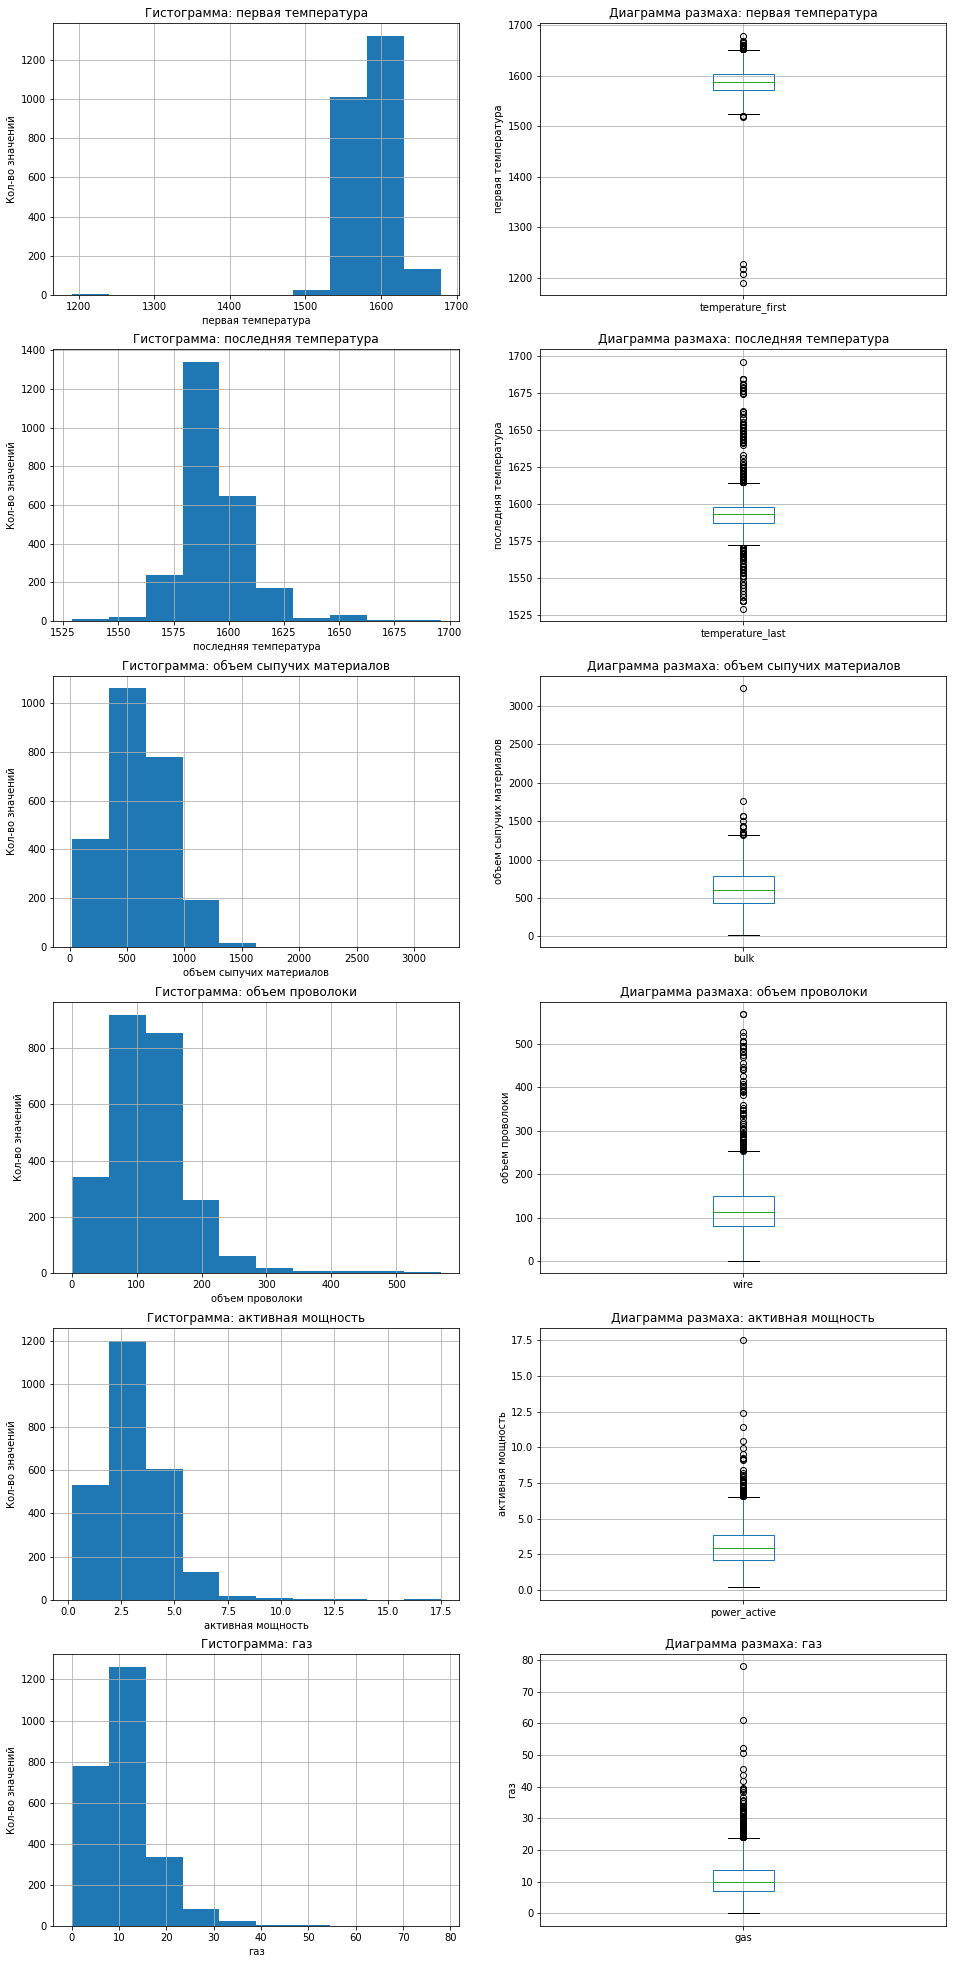

In [23]:
col_names = {'temperature_first': 'первая температура',
             'temperature_last': 'последняя температура',
             'bulk': 'объем сыпучих материалов',
             'wire': 'объем проволоки',
             'power_active': 'активная мощность',
             'gas': 'газ'}

fig, axes = plt.subplots(6, 2, figsize=(16, 35))
num_row = 0
for col_name in col_names.items():
    #Построим гистограмму
    ax1 = df_final[col_name[0]].plot(title='Гистограмма: '+col_name[1],
                                     kind='hist', bins=10, grid=True, ax=axes[num_row, 0])
    ax1.set_xlabel(col_name[1])
    ax1.set_ylabel('Кол-во значений')
    #Построим диаграмму размаха
    ax2 = df_final.boxplot(column=col_name[0], ax=axes[num_row, 1], return_type='axes')
    ax2.set_ylabel(col_name[1])
    ax2.set_title('Диаграмма размаха: '+col_name[1])
    num_row += 1

plt.show()

**По результатам анализа диаграмм размаха и проведения исследовательского анализа в целом можно сделать следующие выводы:**
1. Диапазон нормальных значений для столбца temperature_first: от 1523 до 1651
2. Диапазон нормальных значений для столбца temperature_last: от 1570 до 1615
3. Диапазон нормальных значений для столбца bulk: от 0 до 1320
4. Диапазон нормальных значений для столбца wire: от 0 до 253
5. Диапазон нормальных значений для столбца power_active: от 0 до 6.5
6. Диапазон нормальных значений для столбца gas: от 0 до 24
7. Значения в столбцах за пределами нормальных значений - это выбросы, они находятся за пределами "усов" диаграмм размаха. В целях обеспечения более высокого качества данных для ML-модели, основные выбросы значений в соответствующих столбцах необходимо удалить из датафрейма df_final.

Обработка данных по результатам исследовательского анализа (удаление основных выбросов из датафрейма):

In [24]:
df_final = df_final.query('temperature_first >= 1480 & temperature_first <= 1700 & ' +
                          'temperature_last >= 1565 & temperature_last <= 1659 & ' +
                          'bulk > 0 & bulk <= 1320 & ' +
                          'wire >= 0 & wire <= 290 & ' +
                          'power_active > 0 & power_active <= 7.5 & ' +
                          'gas > 0 & gas <= 32').reset_index(drop = True)
df_final.info()
df_final.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2344 entries, 0 to 2343
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   key                2344 non-null   int64  
 1   temperature_first  2344 non-null   float64
 2   temperature_last   2344 non-null   float64
 3   bulk               2344 non-null   float64
 4   wire               2344 non-null   float64
 5   power_active       2344 non-null   float64
 6   gas                2344 non-null   float64
dtypes: float64(6), int64(1)
memory usage: 128.3 KB


,key,temperature_first,temperature_last,bulk,wire,power_active,gas
count,2344.000000,2344.000000,2344.000000,2344.000000,2344.000000,2344.000000,2344.000000
mean,1300.806741,1587.933020,1594.062713,598.281570,113.689343,3.014997,10.782300
std,756.379345,23.696441,13.110186,270.504808,53.913623,1.301074,5.423914
min,1.000000,1519.000000,1565.000000,19.000000,0.000000,0.186226,0.008399
25%,655.750000,1571.750000,1587.000000,434.000000,81.360242,2.072381,7.096791
50%,1290.500000,1587.000000,1593.000000,602.500000,111.576922,2.931240,9.843015
75%,1925.250000,1603.000000,1598.000000,777.000000,146.699797,3.821979,13.621984
max,3235.000000,1668.000000,1658.000000,1312.000000,288.494973,7.327481,31.961845


**Вывод:**

1. По результатам исследовательского анализа данных были выявлены аномалии (выбросы в данных). Устранение основных аномалий в данных привело к сокращению размера итоговой выборки на 6%.
2. Более глубокий анализ данных выявил следующие особенности:
- целевой признак - последняя измеренная температура после легирования для части выборки выше первоначальной температуры (60%), для части выборки - ниже (35%), для части выборки - температуры равны (5%);
- однозначной закономерности в данных, чтобы указанная выше особенность была подтверждена, не выявлено (например, причинами роста последней температуры является нагревание сплава, а причинами снижения - добавление большего, по сравнению с другими случаями, объема добавок и меньший нагрев сплава);
- в целях создания качественной и эффективной ML-модели для реального бизнеса можно рекомендовать в будущем проведение дополнительных переговоров с заказчиком и поставщиком данных, чтобы более детально изучить технологический процесс и понять, действительно ли такие особенности существуют в реальном бизнесе, или же это некачественно предоставленные данные и требуется их новая подготовка.

## Подготовка обучающей и тестовой выборок

Создадим обучающую (75%) и тестовую (25%) выборки для ML-моделей:

In [25]:
#Разобъем исходную таблицу на две: целевой признак и остальные признаки
df_features = df_final.drop(['key', 'temperature_last'], axis=1)
df_target = df_final['temperature_last']
#Выделим обучающую (75%) и тестовую (25%) выборки из общего набора данных
features_train, features_test, target_train, target_test = train_test_split(
    df_features, df_target, test_size=0.25, random_state=12345)
features_train = features_train.reset_index(drop=True)
features_test = features_test.reset_index(drop=True)
target_train = target_train.reset_index(drop=True)
target_test = target_test.reset_index(drop=True)
#Выведем на экран размеры выборок
print(features_train.shape)
print(target_train.shape)
print(features_test.shape)
print(target_test.shape)

(1758, 5)
(1758,)
(586, 5)
(586,)


## Обучение четырех ML-моделей и подбор гиперпараметров

Создадим функцию для обучения одной из 4-х ML-моделей («линейная регрессия», «градиентный бустинг» библиотек XGBoost, LightGBM и CatBoost), расчета метрики MAE и оценки качества модели кросс-валидацией:

In [26]:
def f_4ML_models_mae_cv(fv_features_train: pd.DataFrame, fv_target_train: pd.Series,
                        fv_modelname: str, fv_max_depth=None, fv_max_estimators=100, fv_learning_rate=1):
    #функция для обучения одной из 4-х моделей, расчета метрики MAE и оценки качества модели кросс-валидацией

    #определим одну из 4-х моделей
    if fv_modelname == 'XGBRegressor':
        model = XGBRegressor(random_state=12345,
                             max_depth=fv_max_depth, n_estimators=fv_max_estimators, learning_rate=fv_learning_rate)
    elif fv_modelname == 'LGBMRegressor':
        model = LGBMRegressor(random_state=12345,
                              max_depth=fv_max_depth, n_estimators=fv_max_estimators, learning_rate=fv_learning_rate)
    elif fv_modelname == 'CatBoostRegressor':
        model = CatBoostRegressor(random_state=12345, loss_function="MAE",
                                  iterations=fv_max_estimators, depth=fv_max_depth, learning_rate=fv_learning_rate,
                                  verbose=False)
    else:
        model = LinearRegression()
    #вычислим метрику MAE с использованием кросс-валидации
    scorer = make_scorer(mean_absolute_error, greater_is_better=True)
    cv_mae = cross_val_score(model, fv_features_train, fv_target_train, scoring=scorer, cv=5).mean()

    return cv_mae

Для модели **«линейная регрессия»** определим значение метрики MAE:

In [27]:
print('значение MAE =',f_4ML_models_mae_cv(features_train, target_train, 'LinearRegression'))

значение MAE = 6.944648939581275


Для модели **«градиентный бустинг» библиотеки XGBoost** определим значения гиперпараметров n_estimators и max_depth для вычисления лучшего значения метрики MAE:

In [28]:
for n_est in range(2000, 2101, 100):
    for depth in range(2, 5, 1):
        print('гиперпараметры n_estimators =', n_est, ', max_depth =', depth, ', значение MAE =',
              f_4ML_models_mae_cv(features_train, target_train, 'XGBRegressor', depth, n_est, 0.01))

гиперпараметры n_estimators = 2000 , max_depth = 2 , значение MAE = 6.137094211454868
гиперпараметры n_estimators = 2000 , max_depth = 3 , значение MAE = 6.1204486369716165
гиперпараметры n_estimators = 2000 , max_depth = 4 , значение MAE = 6.144892834098004
гиперпараметры n_estimators = 2100 , max_depth = 2 , значение MAE = 6.141073237895595
гиперпараметры n_estimators = 2100 , max_depth = 3 , значение MAE = 6.13066938845366
гиперпараметры n_estimators = 2100 , max_depth = 4 , значение MAE = 6.154104475541549


Для модели **«градиентный бустинг» библиотеки LightGBM** определим значения гиперпараметров n_estimators и max_depth для вычисления лучшего значения метрики MAE:

In [29]:
for n_est in range(1760, 1771, 10):
    for depth in range(2, 5, 1):
        print('гиперпараметры n_estimators =', n_est, ', max_depth =', depth, ', значение MAE =',
              f_4ML_models_mae_cv(features_train, target_train, 'LGBMRegressor', depth, n_est, 0.01))

гиперпараметры n_estimators = 1760 , max_depth = 2 , значение MAE = 6.144186289606996
гиперпараметры n_estimators = 1760 , max_depth = 3 , значение MAE = 6.096913238606602
гиперпараметры n_estimators = 1760 , max_depth = 4 , значение MAE = 6.133176798607776
гиперпараметры n_estimators = 1770 , max_depth = 2 , значение MAE = 6.1444775823536855
гиперпараметры n_estimators = 1770 , max_depth = 3 , значение MAE = 6.096998343338983
гиперпараметры n_estimators = 1770 , max_depth = 4 , значение MAE = 6.133822056676118


Для модели **«градиентный бустинг» библиотеки CatBoost** определим значения гиперпараметров iterations и depth для вычисления лучшего значения метрики MAE:

In [30]:
for n_est in range(5317, 5319, 1):
    for depth in range(4, 7, 1):
        print('гиперпараметры iterations =', n_est, ', depth =', depth, ', значение MAE =',
              f_4ML_models_mae_cv(features_train, target_train, 'CatBoostRegressor', depth, n_est, 0.004))

гиперпараметры iterations = 5317 , depth = 4 , значение MAE = 5.948456948720527
гиперпараметры iterations = 5317 , depth = 5 , значение MAE = 5.927564882678799
гиперпараметры iterations = 5317 , depth = 6 , значение MAE = 5.935802829482513
гиперпараметры iterations = 5318 , depth = 4 , значение MAE = 5.948491939081559
гиперпараметры iterations = 5318 , depth = 5 , значение MAE = 5.927566334245602
гиперпараметры iterations = 5318 , depth = 6 , значение MAE = 5.935797874853209


**Вывод:**

1. При обучении 4-х ML-моделей и оценке их качества кросс-валидацией с использованием обучающей выборки достаточные для выполнения проекта значения метрики MAE показали 3 ML-модели - «градиентный бустинг» библиотек XGBoost, LightGBM и CatBoost (условие проекта: значение MAE меньше или равно 6.3 — 5.5 sp).
2. Лучшей является ML-модель «градиентный бустинг» библиотеки CatBoost, значение метрики MAE < 6.

## Прогнозирование четырех ML-моделей на тестовой выборке

Создадим функцию для прогнозирования одной из 4-х ML-моделей («линейная регрессия», «градиентный бустинг» библиотек XGBoost, LightGBM и CatBoost), расчета метрик MAE модели и констатной модели, а также для подготовки данных в целях построения графиков важности признаков модели, исходных и предсказанных данных:

In [31]:
def f_4ML_models_mae(fv_features_train: pd.DataFrame, fv_target_train: pd.Series,
                     fv_features_test: pd.DataFrame, fv_target_test: pd.Series,
                     df_mae: pd.DataFrame, fv_modelname: str, fv_max_estimators=50, fv_max_depth=1, fv_learning_rate=1):
    #функция для прогнозирования и расчета метрики MAE одной из 4-х моделей
    
    #определим одну из 4-х моделей
    if fv_modelname == 'XGBRegressor':
        model = XGBRegressor(random_state=12345,
                             max_depth=fv_max_depth, n_estimators=fv_max_estimators, learning_rate=fv_learning_rate)
    elif fv_modelname == 'LGBMRegressor':
        model = LGBMRegressor(random_state=12345,
                              max_depth=fv_max_depth, n_estimators=fv_max_estimators, learning_rate=fv_learning_rate)
    elif fv_modelname == 'CatBoostRegressor':
        model = CatBoostRegressor(random_state=12345, loss_function="MAE",
                                  iterations=fv_max_estimators, depth=fv_max_depth, learning_rate=fv_learning_rate)
    elif fv_modelname == 'LinearRegression':
        model = LinearRegression()
    else:
        #Константная модель
        model = DummyRegressor(strategy='median')
    
    #обучим модель
    if fv_modelname == 'CatBoostRegressor':
        model.fit(fv_features_train, fv_target_train, eval_set=(fv_features_test, fv_target_test),
                  verbose=False, plot=True)
    else:
        model.fit(fv_features_train, fv_target_train)
    #вычислим метрику MAE
    predict_test = model.predict(fv_features_test)
    mae = mean_absolute_error(fv_target_test, predict_test)
    #сохраним значения MAE для модели и константной модели
    df_mae.loc[df_mae['Модель']==fv_modelname, 'MAE'] = mae
    
    #подготовим данные для построения графика важности признаков модели
    if fv_modelname in ('XGBRegressor', 'LGBMRegressor', 'CatBoostRegressor'):
        feature_importance = model.feature_importances_
    elif fv_modelname in ('LinearRegression'):
        feature_importance = model.coef_
    if fv_modelname in ('XGBRegressor', 'LGBMRegressor', 'CatBoostRegressor', 'LinearRegression'):
        feature_imp = pd.DataFrame(sorted(zip(feature_importance, fv_features_train)), columns=['Value','Feature'])
    else:
        feature_imp = np.nan
    
    #подготовим данные для построения графика исходных и предсказанных данных
    df_target_test = pd.DataFrame(fv_target_test)
    df_target_test.columns=['исходные данные']
    df_target_test['предсказанные данные'] = predict_test
    
    return mae, feature_imp, df_target_test

Создадим датафрейм df_mae для хранения значений метрик MAE моделей:

In [32]:
df_mae = pd.DataFrame(data=[['LinearRegression', np.nan],
                            ['XGBRegressor', np.nan],
                            ['LGBMRegressor', np.nan],
                            ['CatBoostRegressor', np.nan],
                            ['Константная модель', np.nan]],
                      columns=['Модель', 'MAE'])

Вычислим значение метрики MAE для констатной модели тестовой выборки:

In [33]:
mae, feature_imp, df_target_test = f_4ML_models_mae(features_train, target_train, features_test, target_test,
                                                    df_mae, 'Константная модель')
print('MAE константной модели =', mae)

MAE константной модели = 9.786689419795222


### Прогнозирование модели «линейная регрессия» на тестовой выборке

Вычислим значение метрики MAE модели для тестовой выборки, а также построим график важности признаков модели и график исходных и предсказанных данных:

MAE модели LinearRegression = 7.439291557095304


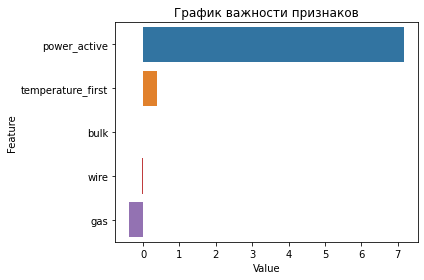

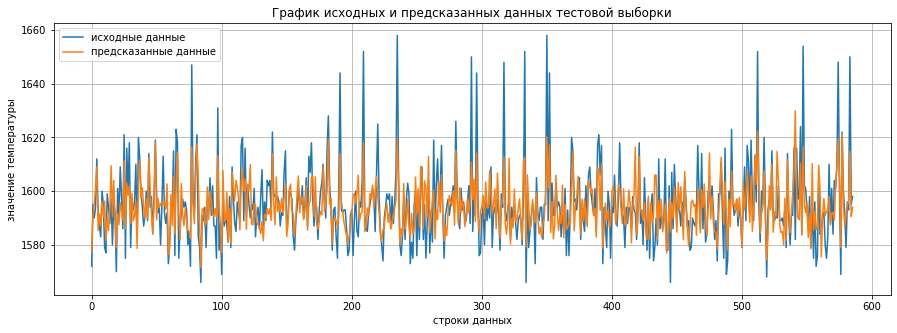

In [34]:
mae, feature_imp, df_target_test = f_4ML_models_mae(features_train, target_train, features_test, target_test,
                                                    df_mae, 'LinearRegression')
print('MAE модели LinearRegression =', mae)
#Построим график важности признаков модели
sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False).iloc[:5])
plt.title('График важности признаков')
plt.tight_layout()
plt.show();
#Построим график исходного и предсказанного рядов тестовой выборки
ax1=df_target_test.plot(title='График исходных и предсказанных данных тестовой выборки', figsize=(15, 5), grid=True)
ax1.set_xlabel('строки данных')
ax1.set_ylabel('значение температуры')
plt.show()

### Прогнозирование модели «градиентный бустинг» библиотеки XGBoost на тестовой выборке

MAE модели XGBRegressor = 6.251078634945606


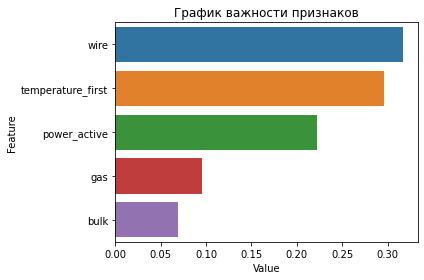

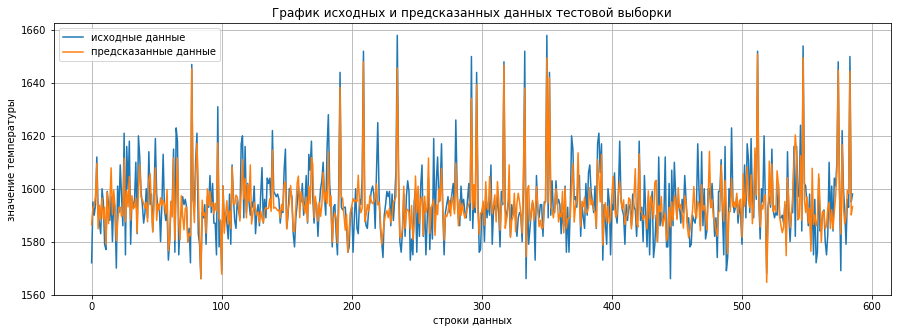

In [35]:
mae, feature_imp, df_target_test = f_4ML_models_mae(features_train, target_train, features_test, target_test,
                                                    df_mae, 'XGBRegressor', 2000, 3, 0.01)
print('MAE модели XGBRegressor =', mae)
#Построим график важности признаков модели
sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False).iloc[:5])
plt.title('График важности признаков')
plt.tight_layout()
plt.show();
#Построим график исходного и предсказанного рядов тестовой выборки
ax1=df_target_test.plot(title='График исходных и предсказанных данных тестовой выборки', figsize=(15, 5), grid=True)
ax1.set_xlabel('строки данных')
ax1.set_ylabel('значение температуры')
plt.show()

### Прогнозирование модели «градиентный бустинг» библиотеки LightGBM на тестовой выборке

MAE модели LGBMRegressor = 6.305247319265741


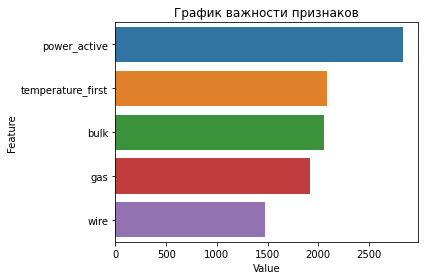

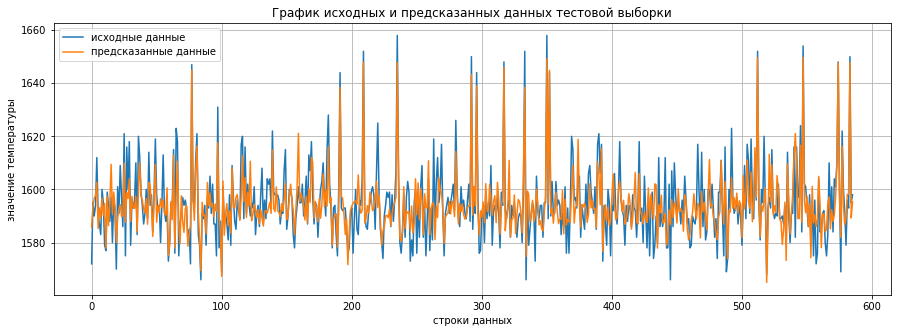

In [36]:
mae, feature_imp, df_target_test = f_4ML_models_mae(features_train, target_train, features_test, target_test,
                                                    df_mae, 'LGBMRegressor', 1760, 3, 0.01)
print('MAE модели LGBMRegressor =', mae)
#Построим график важности признаков модели
sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False).iloc[:5])
plt.title('График важности признаков')
plt.tight_layout()
plt.show();
#Построим график исходного и предсказанного рядов тестовой выборки
ax1=df_target_test.plot(title='График исходных и предсказанных данных тестовой выборки', figsize=(15, 5), grid=True)
ax1.set_xlabel('строки данных')
ax1.set_ylabel('значение температуры')
plt.show()

### Прогнозирование модели «градиентный бустинг» библиотеки CatBoost на тестовой выборке

Вычислим значение метрики MAE модели для тестовой выборки, а также построим график важности признаков модели и график исходных и предсказанных данных:

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

MAE модели CatBoostRegressor = 6.151777148694031


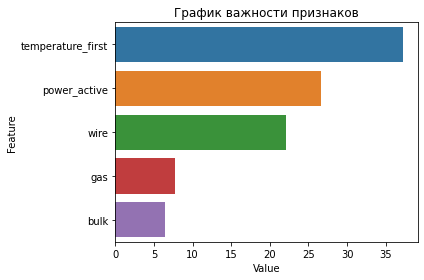

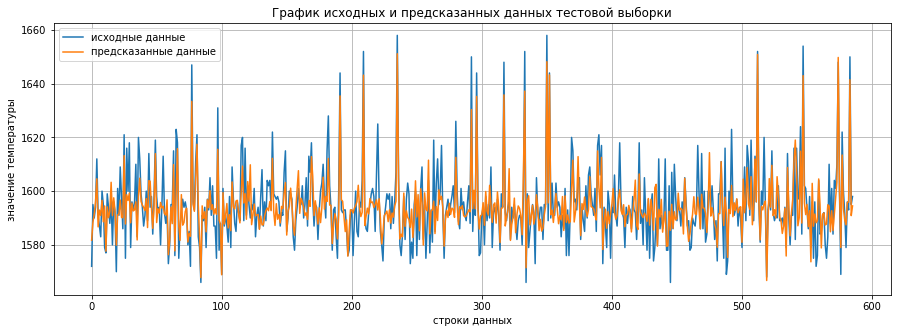

In [37]:
mae, feature_imp, df_target_test = f_4ML_models_mae(features_train, target_train, features_test, target_test,
                                                    df_mae, 'CatBoostRegressor', 5318, 5, 0.004)
print('MAE модели CatBoostRegressor =', mae)
#Построим график важности признаков модели
sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False).iloc[:5])
plt.title('График важности признаков')
plt.tight_layout()
plt.show();
#Построим график исходного и предсказанного рядов тестовой выборки
ax1=df_target_test.plot(title='График исходных и предсказанных данных тестовой выборки', figsize=(15, 5), grid=True)
ax1.set_xlabel('строки данных')
ax1.set_ylabel('значение температуры')
plt.show()

## Общий вывод проекта

Таблица значений метрик MAE моделей на тестовой выборке:

In [38]:
df_mae.head()

,Модель,MAE
0,LinearRegression,7.439292
1,XGBRegressor,6.251079
2,LGBMRegressor,6.305247
3,CatBoostRegressor,6.151777
4,Константная модель,9.786689


**По результатам проекта можно сделать следующие выводы:**
1. Лучшей ML-моделью для прогнозирования оптимальной температуры плавки стали является «градиентный бустинг» библиотеки CatBoost, значение метрики MAE на тестовой выборке = 6.15 (лучшее качество предсказания по сравнению с другими ML-моделями), что соответствует условиям проекта (значение метрики MAE меньше или равно 6.3 — 5.5 sp).
2. Значения метрик MAE на тестовой выборке для моделей градиентного бустинга библиотек XGBoost и LightGBM также соответствуют условиям проекта (меньше или равно 6.3).
3. Стоит отметить, что наиболее важными факторами (признаками) для прогноза оптимальной температуры плавки стали с использованием модели градиентного бустинга библиотеки CatBoost являются первая измеренная температура, активная мощность и объем проволоки, добавляемой при легировании стали.
4. Все ML-модели осуществляют прогноз лучше, чем константная модель (MAE = 9.8). Поэтому, применение указанных ML-моделей является оправданным для бизнеса.

**Для улучшения качества данного проекта и снижения значения метрики MAE в реальном бизнесе я бы сделал следующее:**
1. Если бы была возможность общения с бизнесом я бы выяснил, а есть ли возможность определения и предоставления  значений температур в самом начале перед первой итерацией добавления легирующих добавок, после каждой итерации и в самом конце после последней итерации. Если дополнение данных такими температурами было возможно, то можно было бы определять значение температур для каждой итерации, а не только по партии в целом, а также диапазон первой температуры был бы очень небольшим - зачем греть сплав вначале процесса по разному.<br>
    То же самое было бы и с последней температурой - она должна быть оптимальной, поэтому для одной марки стали диапазон таких температур был бы небольшим. Если диапазоны оптимальных температур для разных марок стали сильно различаются, возможно целесообразно делать ML-модели для каждой группы марок стали с похожими температурными характеристиками.
2. Из набора данных выбрать такие партии, в которых есть сильное различие между фактом и прогнозом и есть аномалии по группе факторов: первая и последняя температуры, активная мощность, объемы добавок. Также, я бы сравнил такие аномалии с другими данными, где первоначальная и последняя температуры примерно аналогичные, а погрешность прогноза очень маленькая. Например, если мы добавляем большой объем добавок и не сильно нагреваем, а последняя температура оказывается выше первоначальной, то температура будет не повышаться, а снижаться и с высокой вероятностью будет ниже первоначальной (конкретные цифры можно увидеть при сравнении данных). Природу таких аномалий необходимо выяснять у бизнеса - здесь либо не все нагревания есть в данных, либо данные ошибочные и их нужно исключить из выборки.<br>
    Таким образом, исключить все аномалии по выбросам и это сильно улучшит качество модели.
3. Рассчитать все простои в секундах между измерениями первой и последней температур (мы может вычислить общее время в секундах между измерениями первой и последней температур и из него вычесть время на нагрев), таким образом, мы уйдем от корреляции с активной мощностью. Также необходимо вычислить время между окончанием итерации легирования (перед измерением последней температуры) и измерением последней температуры, это значение также улучшило бы модель - чем выше это время, тем больше снижается температура. Логика следующая: первая температура увеличивается при нагреве, а снижается - при добавлении добавок, при обработке газом и при простое между нагревами (чем выше простои, тем ниже температура).
4. Также, благодаря контролю времени простоя, можно увеличить производительность и получится, что благодаря модели бизнес не только снизит затраты на "лишнее" нагревание, но и уменьшит время простоя между нагревами и в одну смену можно производить больше партий.